## 🌐 Connect to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/
%cd [2024-2025] AN2DL/Homework 1/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## 🛠 Fix Codabench Dependencies

In [ ]:
# Creates a file in which we specify the versions of the libraries we want
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


## ⚙️ Import Libraries

In [ ]:
import numpy as np
import logging

!pip install keras-cv

import tensorflow as tf
import keras_cv as kcv
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl

# Import other libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Set seeds for NumPy and TensorFlow
seed = 29
np.random.seed(seed)
tf.random.set_seed(seed);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.0 MB/s eta 0:00:00


## ⏳ Load and Clean the Data

In [ ]:
# Load the dataset
data = np.load('training_set.npz')

# Put images on X and labels on y
X = data['images']
y = data['labels']

print("Initial X shape: ", X.shape)
print("Initial y shape: ", y.shape)

# Delete wrong images from dataset
delete_index = 11958
X = X[:delete_index + 1]
y = y[:delete_index + 1]

print("Final X shape: ", X.shape)
print("Final y shape: ", y.shape)

Initial X shape:  (13759, 96, 96, 3)
Initial y shape:  (13759, 1)
Final X shape:  (11959, 96, 96, 3)
Final y shape:  (11959, 1)


## 🖌 Plot the Data

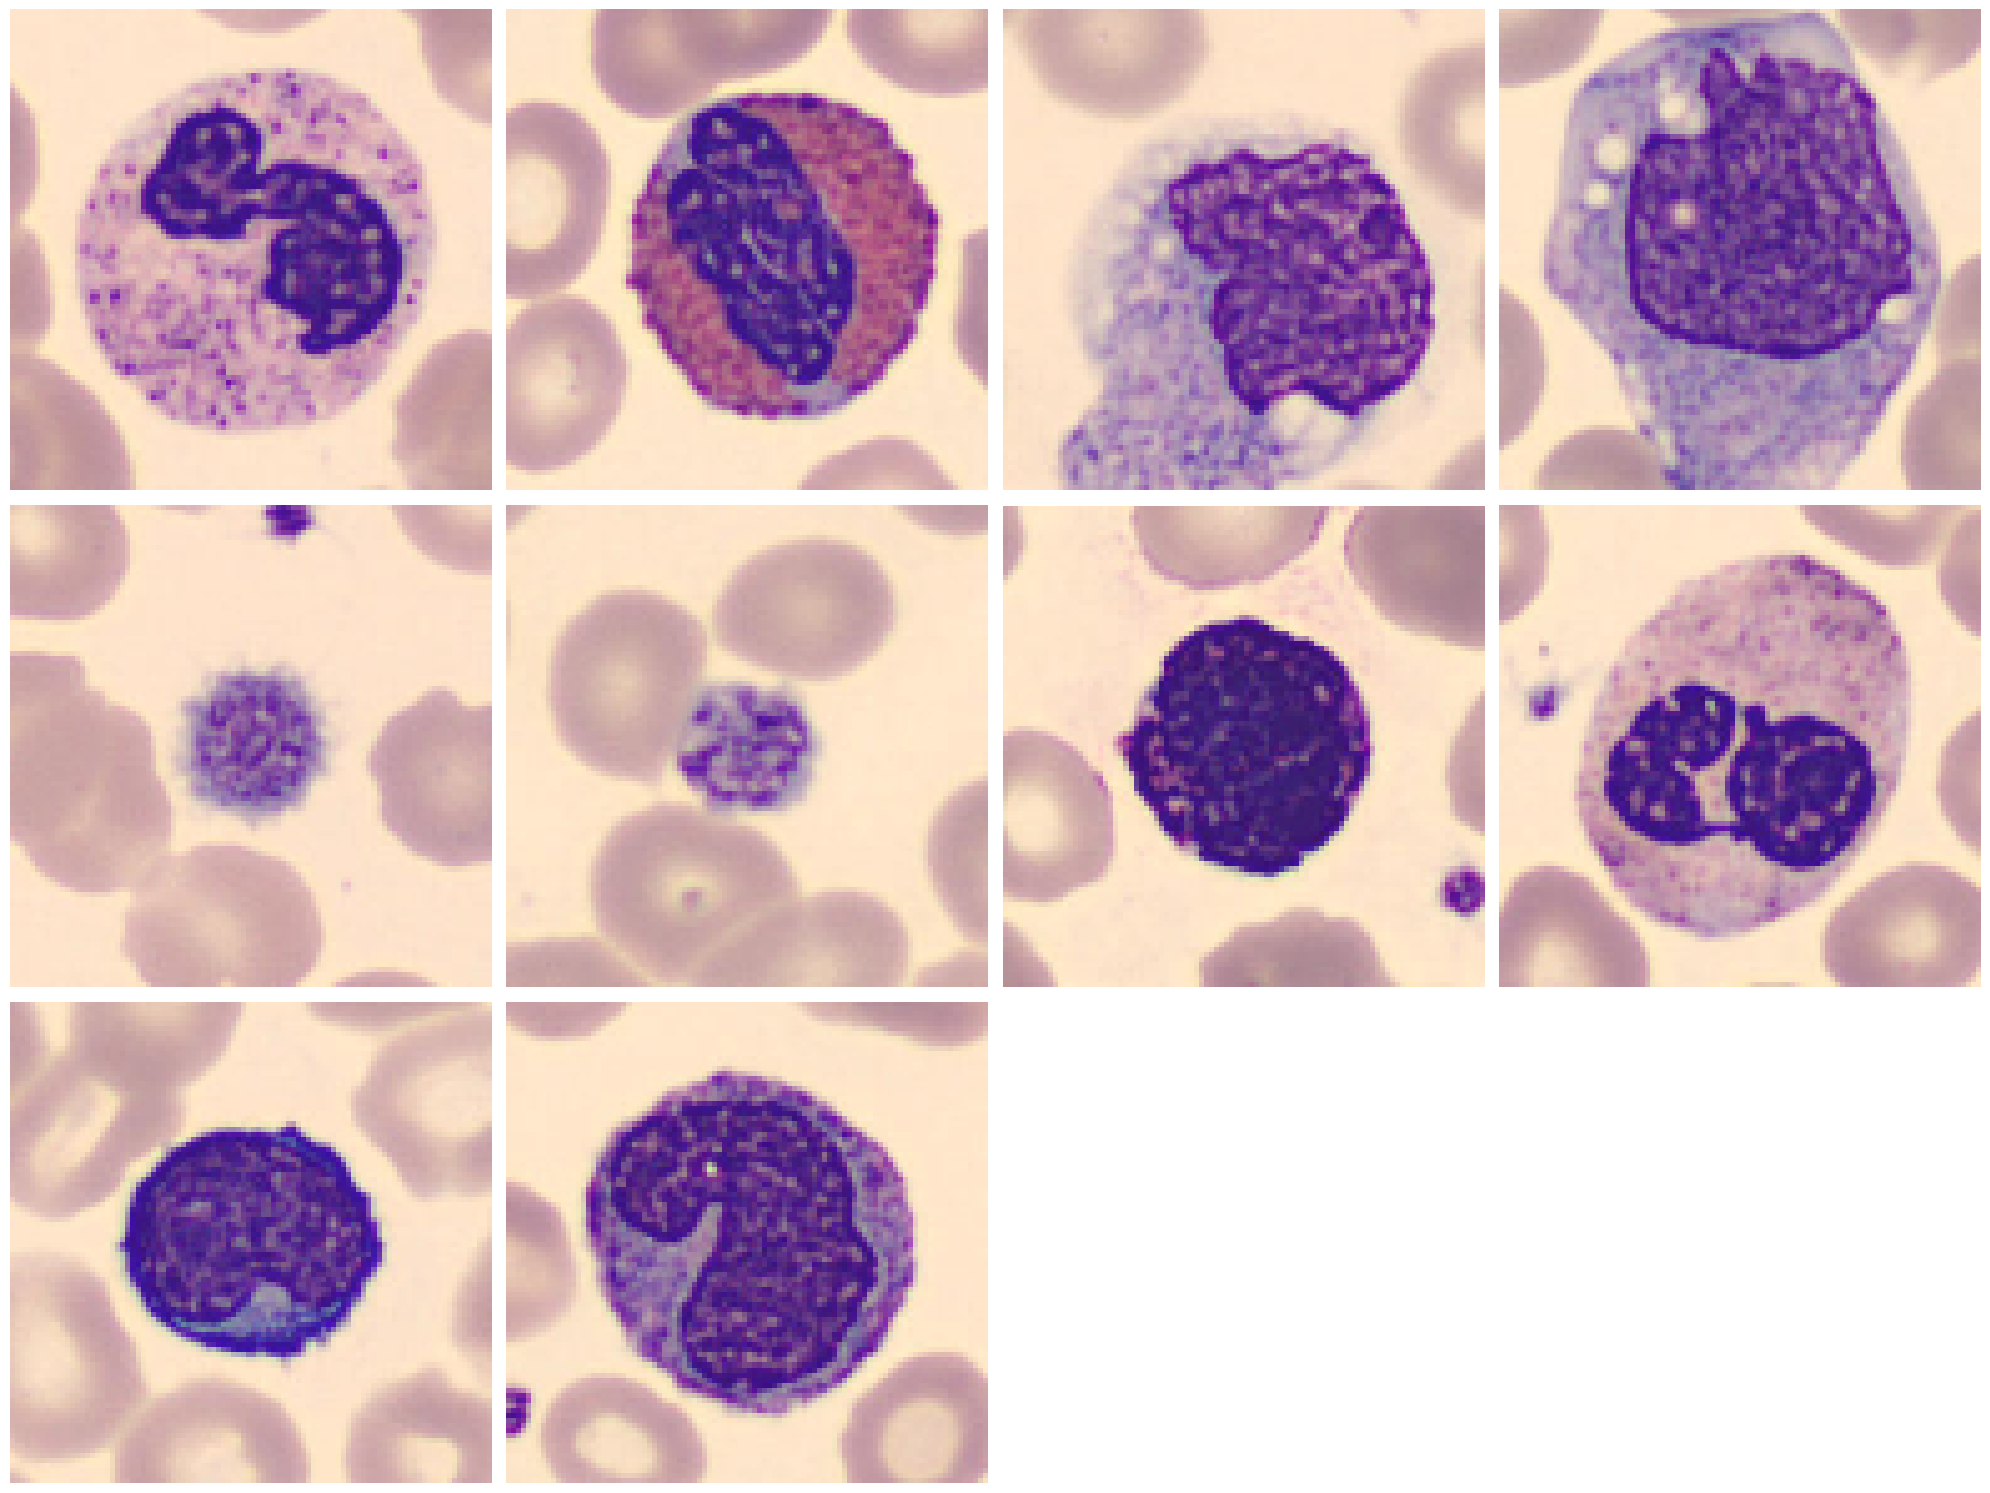

In [ ]:
def plot_images_batch(images, start_index=0, batch_size=200):
    # Prendi un batch di immagini
    end_index = min(start_index + batch_size, len(images))
    images_batch = images[start_index:end_index]

    # Calcola il layout per il plot (es: 10x20 per 200 immagini)
    num_images = len(images_batch)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images_batch[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_images_batch(X, start_index=20, batch_size=10)

## 🚆 Split into train, validation and train sets

In [ ]:
# Split the dataset into a training + validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=seed)

# Further split the training + validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
   test_size=len(X_test),
    stratify=y_train_val,
    random_state=seed)

# Converti le etichette in one-hot encoding
y_train = tfk.utils.to_categorical(y_train, 8)
y_val = tfk.utils.to_categorical(y_val, 8)
y_test = tfk.utils.to_categorical(y_test, 8)

# Assicurati che y_train sia monodimensionale
y_train_flat = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train

# Calcola i pesi di classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)

# Converte i pesi in un dizionario
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Pesi di classe:", class_weights_dict)

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)

Pesi di classe: {0: 1.753482404692082, 1: 0.6853151862464183, 2: 1.379325259515571, 3: 0.7381944444444445, 4: 1.7612297496318114, 5: 1.504245283018868, 6: 0.6415638412017167, 7: 0.9094106463878328}
Training set shape:	 (9567, 96, 96, 3) (9567, 8)
Validation set shape:	 (1196, 96, 96, 3) (1196, 8)
Test set shape:		 (1196, 96, 96, 3) (1196, 8)


## 🧮 Define Network Parameters

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print('Input shape:\t', input_shape)
print('Output shape:\t', output_shape)

# Number of training epochs
epochs = 100

# Number of samples passed to the network at each training step
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 1e-5

# L2 Lambda for regularization
l2_lambda = 1e-5

Input shape:	 (96, 96, 3)
Output shape:	 8


In [ ]:
# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Create a LearningRate Scheduler, which reduces learning rate if val loss doenst improve
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)

# Store the callback in a list
callbacks = [early_stopping, lr_scheduler]

## 🆙  Define Image Augmentation Pipeline

In [ ]:
augmix = kcv.layers.AugMix(
    value_range=(0, 255),
    severity=0.2,
    num_chains=3,
    chain_depth=[1, 2],
    alpha=0.5,
    dtype="float32",
    seed=seed,
)

gridmask = kcv.layers.GridMask(
    ratio_factor=(0, 0.3),
    rotation_factor=0.25,
    fill_mode="constant",
    fill_value=0.0,
    dtype="float32",
    seed=seed,
)

randaugment = kcv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=1,
    magnitude=0.2,
    magnitude_stddev=0.125,
    rate=0.7,
    geometric=True,
    dtype="float32",
    seed=seed,
)


channel_shuffle = kcv.layers.ChannelShuffle(
    dtype="float32",
    seed=seed,
)

random_hue = kcv.layers.RandomHue(
    factor=(0, 0.3),
    value_range=(0, 255),
    dtype="float32",
    seed=seed,
)

random_shear = kcv.layers.RandomShear(
    x_factor=(0, 0.3),
    y_factor=(0, 0.3),
    interpolation="bilinear",
    fill_mode="constant",
    fill_value=0.0,
    dtype="float32",
    seed=seed,
)

random_flip = tfk.layers.RandomFlip("horizontal_and_vertical")
random_rotation = tfk.layers.RandomRotation(0.3)

augmentation = tfk.Sequential([
    augmix,
    gridmask,
    randaugment,
    channel_shuffle,
    random_hue,
    random_shear,
    random_flip,
    random_rotation,
])

tfk.mixed_precision.set_global_policy('float32')

## ⏯ Preprocess dataset

In [ ]:
# Definisci la funzione di preprocessamento e casting
def preprocess_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)  # Normalizzazione specifica
    return image


def apply_augmentation(image, label):
    image = augmentation(image)
    image = tf.cast(image, dtype=tf.float32)
    return image, label

# Create the training datasets, both with and without augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=12000, seed=seed)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda img, label: (preprocess_image(img), label), num_parallel_calls=tf.data.AUTOTUNE)
orig_dataset = train_dataset.map(lambda x, y: (x, y))

augmented_train_dataset  = train_dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
augmented_train_dataset2 = train_dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# Merge Datasets
train_dataset = train_dataset.concatenate(augmented_train_dataset)
train_dataset = train_dataset.concatenate(augmented_train_dataset2)
train_dataset = train_dataset.shuffle(buffer_size=25000, seed=seed)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Create the validation dataset without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

## 🖌 Plot Datasets

Original Dataset:


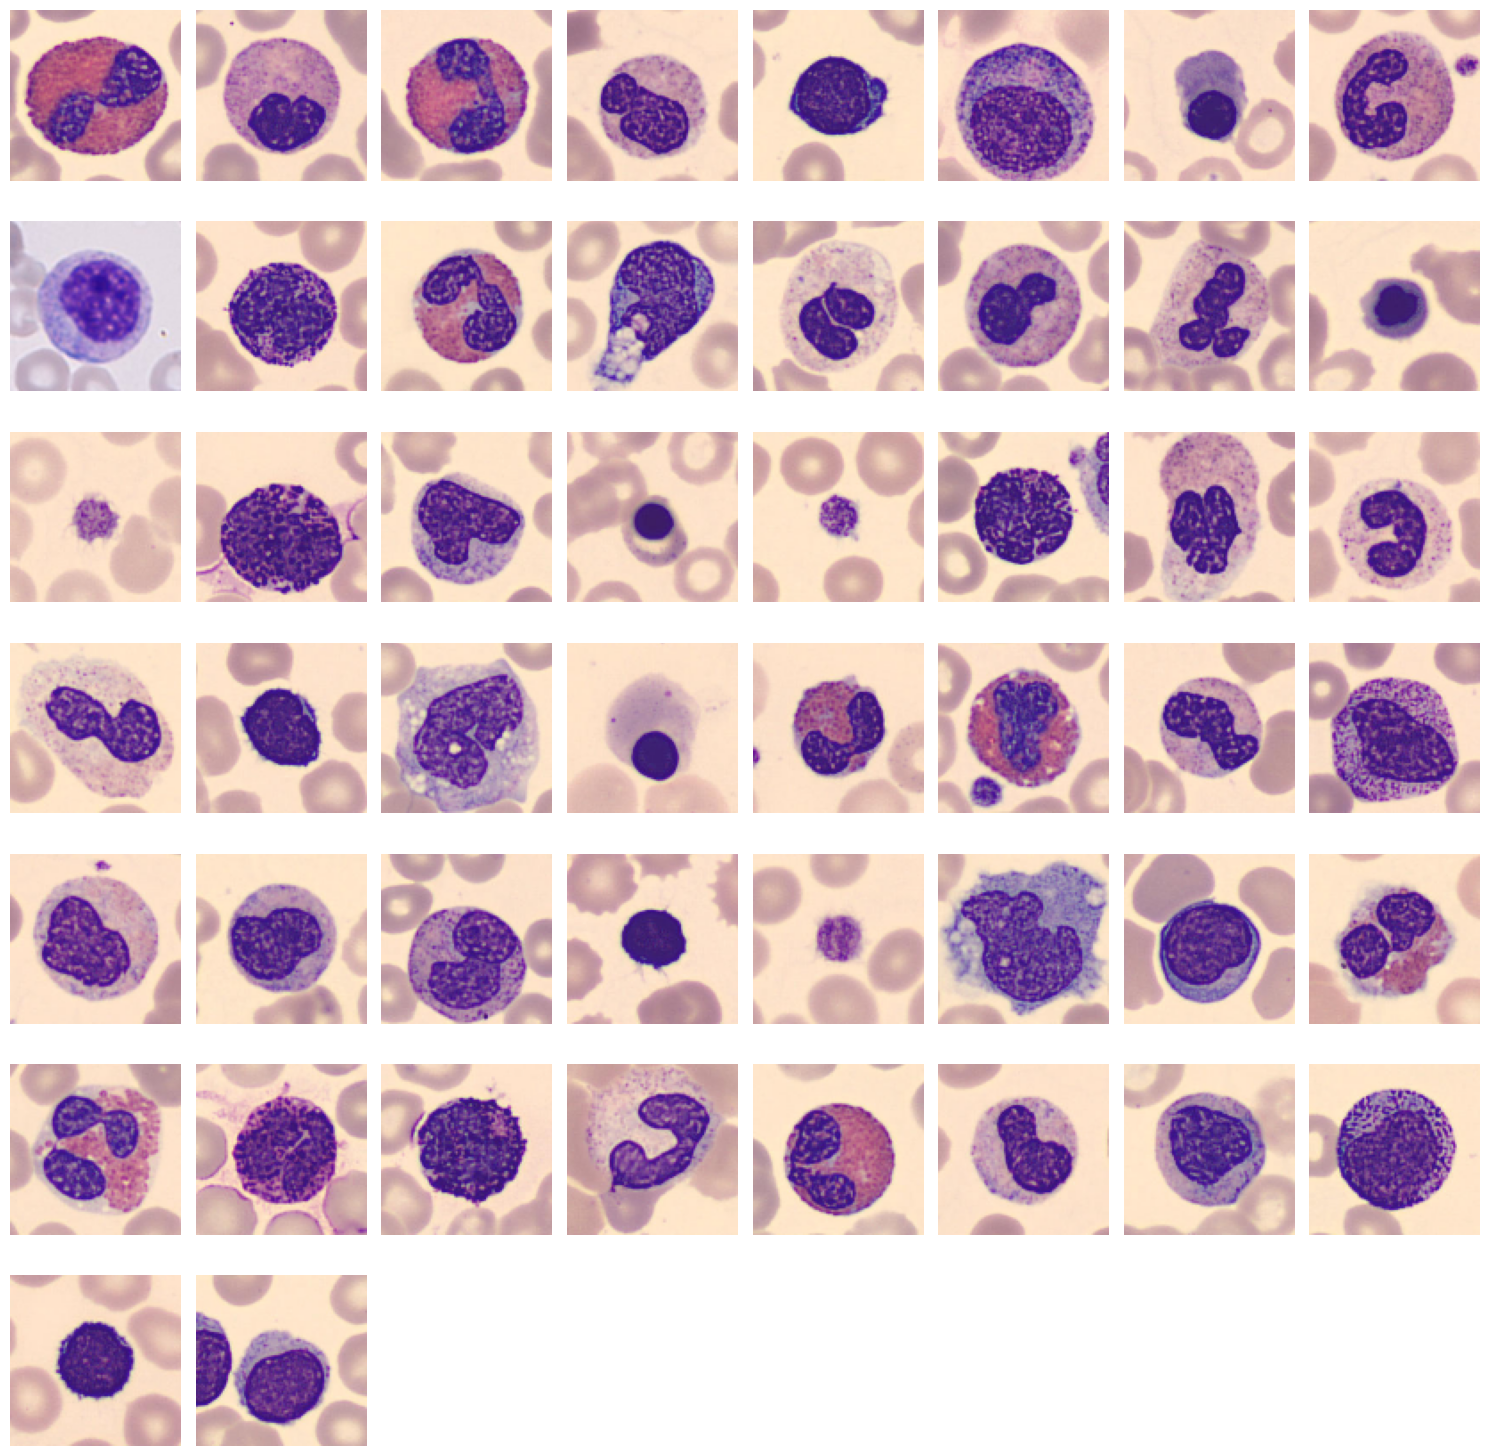

Augmented Dataset:


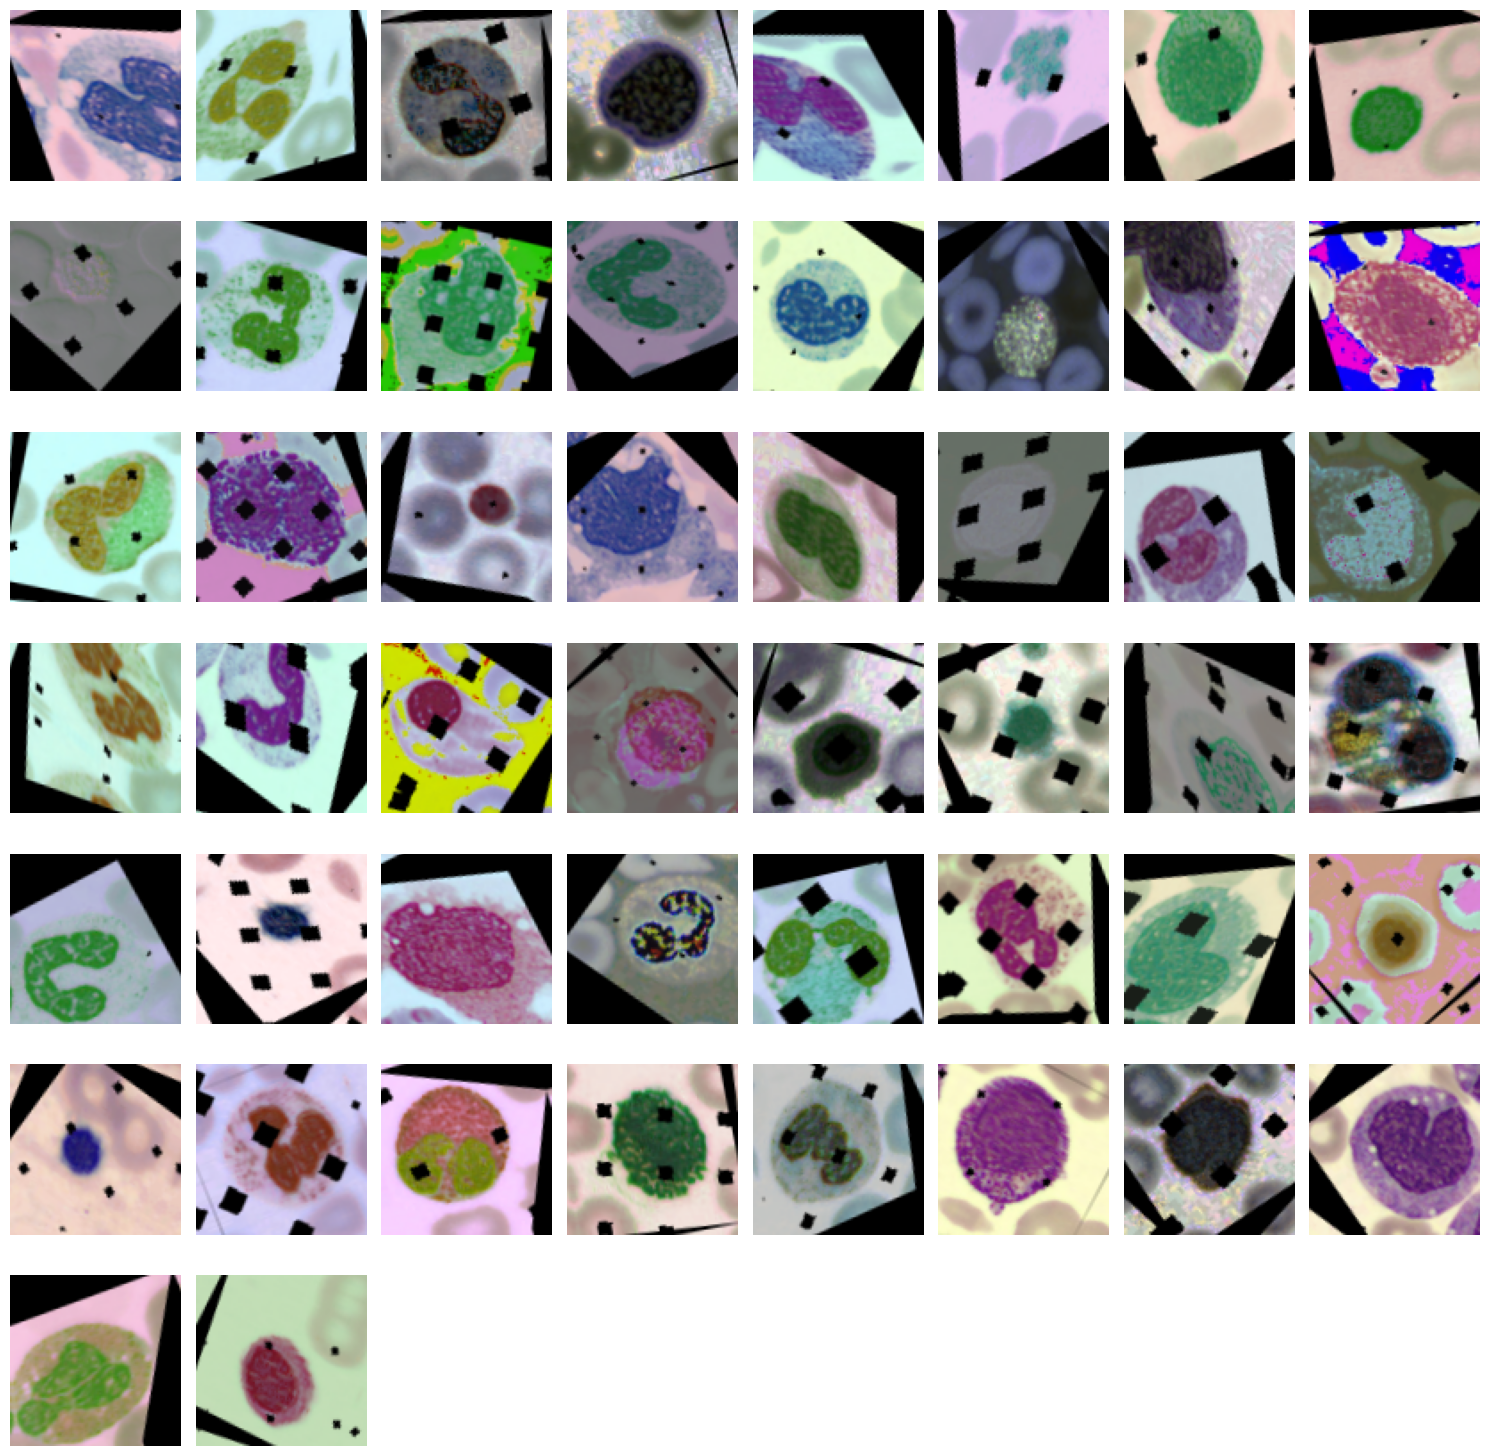

Mixed Dataset:


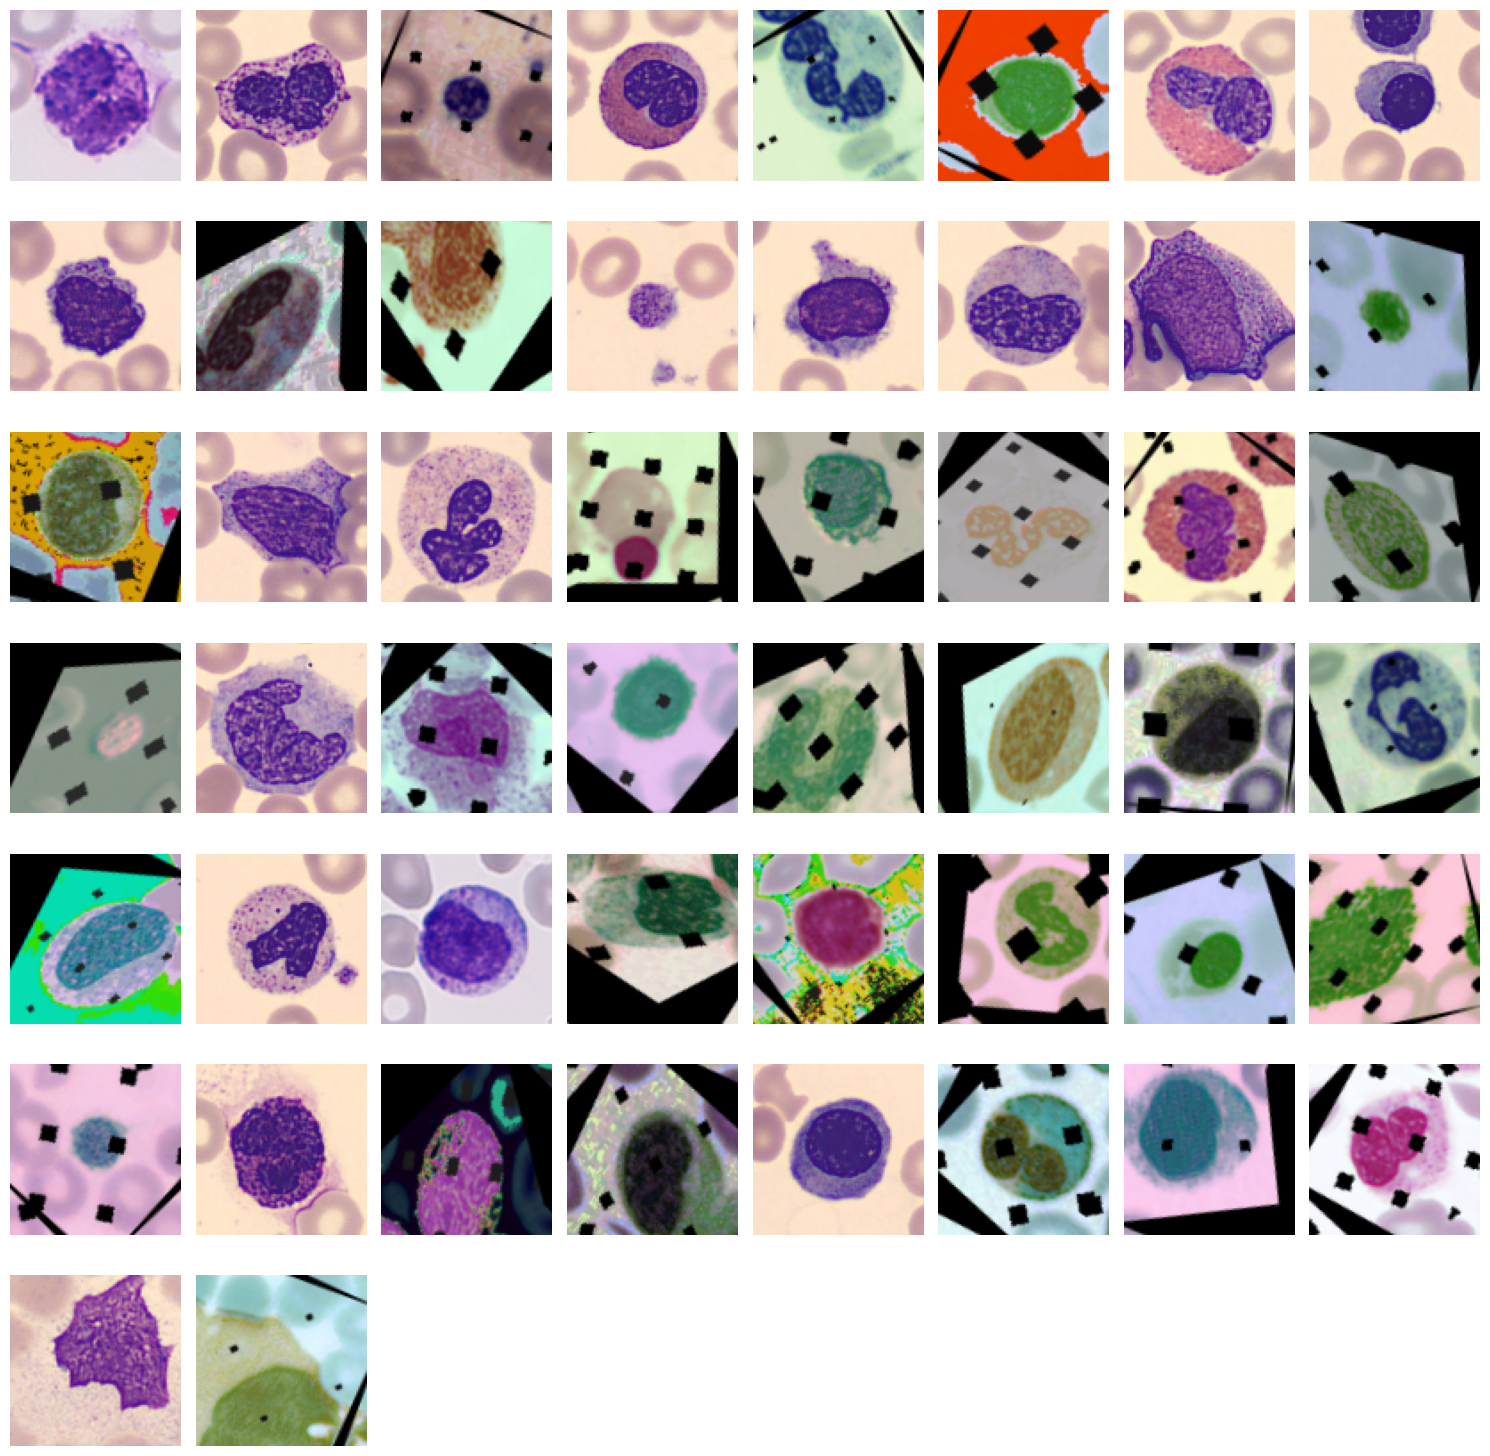

In [ ]:
def plot_images_from_dataset(dataset, num_images=50):

    # Prepare a dataset iterator
    dataset_iterator = iter(dataset)

    # Calculate the number of rows and columns for the grid
    rows = int(num_images ** 0.5)
    cols = (num_images + rows - 1) // rows  # Round Up

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        try:
            # Get a batch of images and labels
            images, labels = next(dataset_iterator)

            # Take first image from the batch
            image = images[0].numpy().astype("uint8")

            # Plot the image
            plt.subplot(rows, cols, i + 1)
            plt.imshow(image)
            plt.axis('off')
        except StopIteration:
            print("Non ci sono abbastanza immagini nel dataset.")
            break

    plt.tight_layout()
    plt.show()

# Plot images from the datasets
print("Original Dataset:")
plot_images_from_dataset(orig_dataset, num_images=50)
print("Augmented Dataset:")
plot_images_from_dataset(augmented_train_dataset, num_images=50)
print("Mixed Dataset:")
plot_images_from_dataset(train_dataset, num_images=50)

## 🔨 Import and tune the Model

In [ ]:
# Import and initialize EfficientNetV2
model = tfk.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False, # NO Fully Connected Blocks
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    classes=output_shape,
)


# Freeze all layers to use the model solely as a feature extractor
model.trainable = False

# Create input layer
inputs = tfkl.Input(shape=input_shape)

regularizer = tfk.regularizers.L2(l2_lambda)

# Connect model with inputs
x = model(inputs)

# Add layers
x = tfkl.BatchNormalization()(x)
x = tfkl.Dense(units=512, activation='relu', kernel_regularizer=regularizer)(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)
x = tfkl.Dense(units=256, activation='relu', kernel_regularizer=regularizer)(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3)(x)


# Setup Fully Connected Blocks
outputs = tfkl.Dense(units=output_shape, activation='softmax')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs)

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Lion(learning_rate=learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


## 🧠 Train the Model for Transfer Learning

In [ ]:
# Train the model
tl_history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_dataset),
    callbacks=callbacks
).history

print('Training finished.')

# Calculate and print the final validation accuracy
tl_final_val_accuracy = round(max(tl_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {tl_final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
tl_model_filename = 'EfficientNetV2M' + str(tl_final_val_accuracy) + '.keras'
model.save(tl_model_filename)

# Free memory by deleting the model instance
del model

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 189s 144ms/step - accuracy: 0.2137 - loss: 2.6385 - val_accuracy: 0.7625 - val_loss: 0.7834 - learning_rate: 1.0000e-05
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 73s 24ms/step - accuracy: 0.4461 - loss: 1.7429 - val_accuracy: 0.8286 - val_loss: 0.5562 - learning_rate: 1.0000e-05
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 73s 24ms/step - accuracy: 0.5114 - loss: 1.4983 - val_accuracy: 0.8395 - val_loss: 0.5068 - learning_rate: 1.0000e-05
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 73s 24ms/step - accuracy: 0.5620 - loss: 1.3181 - val_accuracy: 0.8462 - val_loss: 0.4749 - learning_rate: 1.0000e-05
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 73s 24ms/step - accuracy: 0.5677 - loss: 1.2973 - val_accuracy: 0.8595 - val_loss: 0.4554 - learning_rate: 1.0000e-05
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 74s 24ms/step - accuracy: 0.5770 - loss: 1.2627 - val_accuracy: 0.8687 - val_loss: 0.4302 - learning_rate: 1.0000e-05
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 74s

In [ ]:
# Test Model after Transfer Learning
# Load the model
model = tfk.models.load_model(tl_model_filename)

# Effettua le predizioni sul set di test e di validation
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Converti le predizioni in etichette di classe
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Converti le etichette in formato di classe per il confronto (da one-hot encoding)
y_test_classes = np.argmax(y_test, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calcola l'accuratezza manualmente
test_accuracy = np.sum(y_test_classes == y_pred_test_classes) / len(y_test_classes)
val_accuracy = np.sum(y_val_classes == y_pred_val_classes) / len(y_val_classes)

print(f'Accuracy sul set di validation: {val_accuracy:.4f}')
print(f'Accuracy sul set di test: {test_accuracy:.4f}')

del model

38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 432ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy sul set di validation: 0.9047
Accuracy sul set di test: 0.8804


## 🔧 Fine Tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model(tl_model_filename)

# Set the model layers as trainable
ft_model.get_layer('efficientnetv2-m').trainable = True

# Set all layers as non-trainable
for layer in ft_model.get_layer('efficientnetv2-m').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

In [ ]:
# Set the number of layers to freeze
N = 150

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers[:N]):
    layer.trainable = False

# Compile the model
loss = tfk.losses.CategoricalCrossentropy() # Because no one-hot encoding
optimizer = tfk.optimizers.Lion(learning_rate=learning_rate)
metrics = ['accuracy']
ft_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## 🧠 Train Fine-Tuned Model

In [ ]:
# Train the model
ft_history = ft_model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_dataset),
    callbacks=callbacks
).history

print('Training finished.')

# Calculate and print the final validation accuracy
ft_final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {ft_final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
ft_model_filename = 'EfficientNetV2M' + str(ft_final_val_accuracy) + '.keras'
ft_model.save(ft_model_filename)
ft_model.save('weights.keras')

# Free memory by deleting the model instance
del ft_model

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 227s 177ms/step - accuracy: 0.7948 - loss: 0.5930 - val_accuracy: 0.9674 - val_loss: 0.1317 - learning_rate: 1.0000e-05
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 86s 51ms/step - accuracy: 0.9125 - loss: 0.2735 - val_accuracy: 0.9724 - val_loss: 0.0963 - learning_rate: 1.0000e-05
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 86s 50ms/step - accuracy: 0.9317 - loss: 0.2213 - val_accuracy: 0.9774 - val_loss: 0.0755 - learning_rate: 1.0000e-05
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 87s 52ms/step - accuracy: 0.9379 - loss: 0.1968 - val_accuracy: 0.9791 - val_loss: 0.0810 - learning_rate: 1.0000e-05
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 87s 52ms/step - accuracy: 0.9447 - loss: 0.1797 - val_accuracy: 0.9816 - val_loss: 0.0747 - learning_rate: 1.0000e-05
Training finished.
Final validation accuracy: 98.16%


In [ ]:
# Load the model
model = tfk.models.load_model(ft_model_filename)

# Effettua le predizioni sul set di test e di validation
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Converti le predizioni in etichette di classe
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Converti le etichette in formato di classe per il confronto (da one-hot encoding)
y_test_classes = np.argmax(y_test, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calcola l'accuratezza manualmente
test_accuracy = np.sum(y_test_classes == y_pred_test_classes) / len(y_test_classes)
val_accuracy = np.sum(y_val_classes == y_pred_val_classes) / len(y_val_classes)

print(f'Accuracy sul set di validation: {val_accuracy:.4f}')
print(f'Accuracy sul set di test: {test_accuracy:.4f}')

del model

38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 349ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy sul set di validation: 0.9866
Accuracy sul set di test: 0.9841


## 📊 Create the model.py

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


## 📁 Export the ZIP file

In [ ]:
# Set filename for the zip file
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create a zip file with the provided filename, containing model and weights
!zip {filename} model.py weights.keras

  adding: model.py (deflated 48%)
  adding: weights.keras (deflated 6%)
